****
# Generative Models: Autoencoders, VAEs and GANs
****
<p style="text-align: right"><i>Jesus Perez Colino<br>First version: December 2020<br></i></p>

## About this notebook: 
****
Notebook prepared by **Jesus Perez Colino** Version 0, First Released: 15/12/2020, Alpha

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful. 


- **Summary**: 

>This notebook aim to give a couple of examples of how to build with Keras and Tensorflow, generative models. 

- **Index**: 
    1. Autoencoders
    2. Variational Autoencoders (VAEs)
    3. GANs (plain-vanilla)


In [1]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses

import watermark
import warnings
warnings.filterwarnings('ignore')

%load_ext watermark
print(' Reproducibility conditions for this notebook '.center(85,'-'))
%watermark -n -v -m -p numpy,scipy,matplotlib,tensorflow,keras
print('-'*85)

-------------------- Reproducibility conditions for this notebook -------------------
Sun Apr 18 2021 

CPython 3.7.10
IPython 7.21.0

numpy 1.19.2
scipy 1.6.2
matplotlib 3.3.4
tensorflow 1.15.0
keras 2.3.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
-------------------------------------------------------------------------------------


Using TensorFlow backend.


****
## 1. Autoencoders

An autoencoder is a neural network that is trained to attempt to copy its input to its output. 

Roughly speaking, it will encode the input distribution into a low-dimensional tensor, which usually takes the form of a vector. This will approximate the hidden structure that is commonly referred to as the latent representation, code, or vector. This process constitutes the encoding part. The latent vector will then be decoded by the decoder part to recover the original input.

As a result of the latent vector being a low-dimensional compressed representation of the input distribution, it should be expected that the output recovered by the decoder can only approximate the input. The dissimilarity between the input and the output can be measured by a loss function.

The idea of autoencoders has been part of the historical literature of neural networks for decades (LeCun (1987), Bourlard and Kamp (1988), Hinton and Zemel(1994)). Actually, they can be seen as a special case of feedforward networks, and may be trained with all the same techniques: minibatch gradient descent following gradients computed by back-propagation.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [5]:
class_names = ['Zero', 'One', 'Two', 'Three', 'Four',
               'Five', 'Six', 'Seven', 'Eight', 'Nine']

In [41]:
import math

def plot_data(num_images, images, labels):
    grid = math.ceil(math.sqrt(num_images))
    plt.figure(figsize=(grid*2,grid*2))
    for i in range(num_images):
        plt.subplot(grid,grid,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)     
        plt.imshow(images[i].reshape(28,28))
        plt.xlabel(class_names[labels[i]])      
    plt.show()


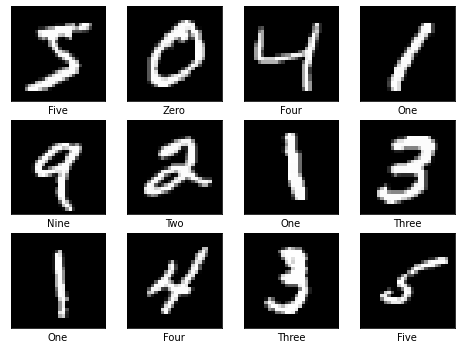

In [43]:
plot_data( 12, x_train, y_train)

In [8]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

### 1. Encoder: 

The 'encoder' neural network defined below, transforms the input, x, into a low-dimensional latent vector, 𝒛 = 𝑓(𝒙) . Since the latent vector is of low dimension, the encoder is forced to learn only the most important features of the input data. For example, in the case of MNIST digits, the important features to learn may include writing style, tilt angle, roundness of stroke, thickness, and so on. Essentially, these are the most important bits of information needed to represent the digits zero to nine.

In the example here below, x can be an MNIST digit that has a dimension of 28 × 28 × 1 = 784. The encoder transforms the input into a low-dimensional z that can be a 32-dimension latent vector.

In [9]:
input_img = Input(shape=(784,))
encoding_dim = 32

encoded = Dense(encoding_dim, activation='relu')(input_img)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### 2. Decoder: 

The 'decoder' neural network tries to recover the input from the latent vector, 𝑔(𝒛) =𝒙'.

Although the latent vector has a low dimension, it has a sufficient size to allow the decoder to recover the input data.
The goal of the decoder is to make 𝒙' as close as possible to x. Generally, both the encoder and decoder are non-linear functions. The dimension of z is a measure of the number of salient features it can represent. The dimension is usually much smaller than the input dimensions for efficiency and in order to constrain the latent code to learn only the most salient properties of the input distribution

In [10]:
decoded = Dense(784, activation='sigmoid')(encoded)

In [11]:
# autoencoder = Minimize (decoder(encoder(original_data)) - original_data)

autoencoder = Model(input_img, decoded)
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [12]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [38]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0101 - val_loss: 0.0098
Epoch 2/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0101 - val_loss: 0.0098
Epoch 3/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0101 - val_loss: 0.0098
Epoch 4/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0100 - val_loss: 0.0098
Epoch 5/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0100 - val_loss: 0.0097
Epoch 6/10
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0100 - val_loss: 0.0097
Epoch 7/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0100 - val_loss: 0.0097
Epoch 8/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0100 - val_loss: 0.0097
Epoch 9/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0100 - val_

Aleternatively, and probably cleaner, we can encapsulate all the code showed before in the following class: 

In [29]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

class Autoencoder(Model):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = encoding_dim   
        self.encoder = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(encoding_dim, activation='relu'), ])
        self.decoder = tf.keras.Sequential([layers.Dense(784, activation='sigmoid'),
                                            layers.Reshape((28, 28))])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(encoding_dim)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0710 - val_loss: 0.0425
Epoch 2/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0356 - val_loss: 0.0297
Epoch 3/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.0269 - val_loss: 0.0237
Epoch 4/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0220 - val_loss: 0.0196
Epoch 5/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0186 - val_loss: 0.0169
Epoch 6/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0162 - val_loss: 0.0148
Epoch 7/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0145 - val_loss: 0.0134
Epoch 8/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 9/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.0124 - val_

In [34]:
autoencoder.summary()

Model: "autoencoder_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   multiple                  25120     
_________________________________________________________________
sequential_19 (Sequential)   multiple                  25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


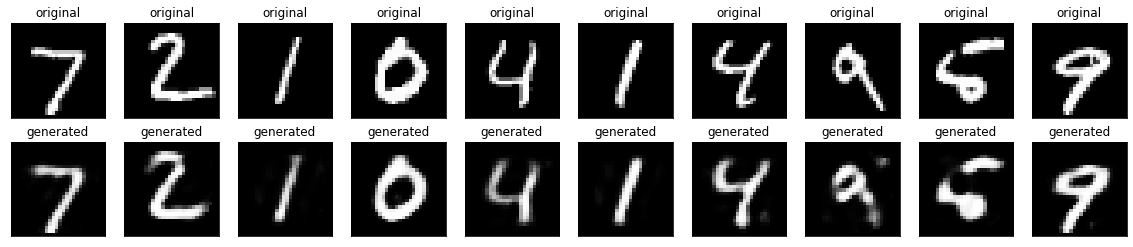

In [44]:
generated = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated[i])
    plt.title("generated")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

****
## 2. Variational Autoencoder (VAE)

In a generative model, we're often interested in approximating the true distribution of our inputs using neural networks.
For example, in the MNIST dataset, this distribution should be able to generate recognizable handwritten digits.

In machine learning, to perform a certain level of inference, we're interested in finding $𝑃_𝜃(𝒙, 𝒛)$, a joint distribution between inputs, 𝒙, and latent variables, 𝒛. The latent variables are not part of the dataset but instead encode certain properties
observable from inputs. In the context of the MNIST dataset, the latent variables may represent the digit and writing styles. In other words, considering all of the possible attributes, we end up with the distribution that describes the inputs. In the MNIST dataset, if we consider all of the possible digits, writing styles, and so on, we end up with the distribution of handwritten digits.

The **variational autoencoder** or VAE (Kingman (2013), Rezende et al.(2014)) is a directed model that uses learned approximate inference and can be trained purely with gradient-based methods. The main idea behind the VAE is to train a parametric encoder that produce the parameters 𝜃 of $𝑃_𝜃(𝒙, 𝒛)$. 
The structure of VAE bears a resemblance to a typical autoencoder. The difference is mainly on the sampling of the Gaussian random variables in the reparameterization trick. The **encoder** is just a two-layer MLP, with the second layer generating the mean and log variance. The use of log variance is for simplicity in the computation of KL loss and the reparameterization trick. The third output of the encoder is the sampling of 𝒛 using the reparameterization trick. The **decoder** is also a two-layer MLP that takes samples of 𝒛 to approximate the inputs. Both the encoder and the decoder use an intermediate dimension with a size of 256.

In [55]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [64]:
batch_size = 32
original_dim = 784
latent_dim = 2 
intermediate_dim = 256
epochs = 10

In [57]:
x = Input(shape=(original_dim,))
x1 = Dense(original_dim//2, activation='relu')(x)
x2 = Dense(original_dim//3, activation='relu')(x1)
h = Dense(intermediate_dim, activation='relu')(x2)

In [58]:
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [59]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [60]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
dc1 = Dense(original_dim//3, activation='relu')
dc2 = Dense(original_dim//2, activation='relu')

h_decoded = decoder_h(z)
h_decoded = dc1(h_decoded)
h_decoded = dc2(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

In [61]:
xent_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=-1)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

In [62]:
vae = Model(x, x_decoded_mean)

vae.add_loss(vae_loss)
optimizer = tf.keras.optimizers.Adam(amsgrad=True)
vae.compile(optimizer=optimizer )
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 392)          307720      input_4[0][0]                    
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 261)          102573      dense_31[0][0]                   
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 256)          67072       dense_32[0][0]                   
____________________________________________________________________________________________

In [65]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 358us/sample - loss: 149.0819 - val_loss: 147.3662
Epoch 2/10
60000/60000 [==============================] - 21s 350us/sample - loss: 146.5228 - val_loss: 145.1972
Epoch 3/10
60000/60000 [==============================] - 23s 379us/sample - loss: 144.9224 - val_loss: 143.8971
Epoch 4/10
60000/60000 [==============================] - 23s 387us/sample - loss: 143.8662 - val_loss: 143.7770
Epoch 5/10
60000/60000 [==============================] - 22s 367us/sample - loss: 143.5781 - val_loss: 143.0381
Epoch 6/10
60000/60000 [==============================] - 19s 314us/sample - loss: 142.4622 - val_loss: 143.8284
Epoch 7/10
60000/60000 [==============================] - 23s 386us/sample - loss: 142.2559 - val_loss: 141.6048
Epoch 8/10
60000/60000 [==============================] - 26s 438us/sample - loss: 141.2890 - val_loss: 140.9887
Epoch 9/10
60000/60000 [======================

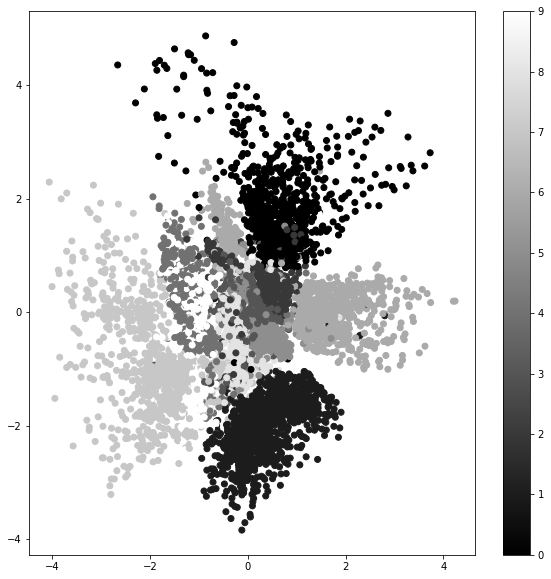

In [66]:
encoder = Model(x, z_mean)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [67]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_h_decoded = dc1(_h_decoded)
_h_decoded = dc2(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

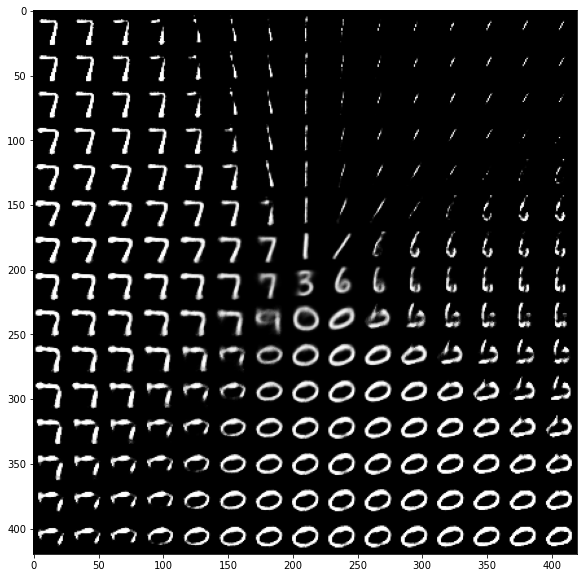

In [68]:
n = 15  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1.0
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)

****
## 3. GANs (plain-vanilla)

GANs are able to learn how to model the input distribution by training two competing (and cooperating) networks referred to as **generator** and **discriminator**. 

> **Generator** - The role of the generator is to keep on figuring out how to generate fake data or signals (this includes audio and images) that can fool the discriminator. Basically, it takes the role of a 'forger' and tries to create music/image/speech/time-series from random noise. It learns to map from a latent space to a particular data distribution of interest. 

> **Discriminator**-  the discriminator is trained to distinguish between fake and real signals. As the training progresses, the discriminator will no longer be able to see the difference between the synthetically generated data and the real data. From there, the discriminator can be discarded, and the generator can then be used to create new realistic data that have never been observed before (synthetic data).

That idea of putting two neural networks to work one against the other, mathematically speaking, can be implemented as the following optimization problem:

* The Generator tries to maximize the probability of fooling the Discriminator by making the images (for example) more close to real in each step, thereby making the Discriminator classify them as real.
* And the Discriminator guides the Generator to produce more realistic images by classifying its images as fake.

In deep learning, both the generator and discriminator can be implemented using a suitable neural network architecture. If the data or signal is an image, both the generator and discriminator networks will use a CNN. For single-dimensional sequences such as audio, both networks are usually recurrent (RNN, LSTM, or GRU).

In [69]:
def load_real_samples():    
    (x_train, _), (_, _) = load_data()    
    X = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))    
    X = X.astype('float32')    
    X = X / 255.0
    return X

In [70]:
dataset = load_real_samples()
print(dataset.shape)

(60000, 784)


In [71]:
def save_plot(examples, n=10):  
    plt.figure(figsize=(10,10))
    for i in range(n * n):      
        plt.subplot(n, n, 1 + i)      
        plt.axis('off')      
        plt.imshow(examples[i].reshape(28,28), cmap='gray_r')  
    plt.show()

(100, 784)


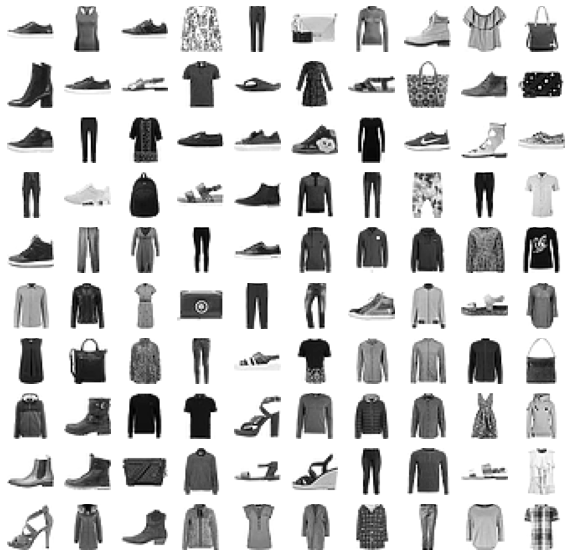

In [72]:
def generate_real_samples(dataset, n_samples):
    ix = R.randint(0, dataset.shape[0], n_samples)    
    X = dataset[ix]    
    y = np.ones((n_samples, 1))
    return X, y

real = generate_real_samples(dataset, 100)
print(real[0].shape)
save_plot(real[0])

In [73]:
latent_dim = 100

def build_generator(latent_dim):
    model = Sequential()    
    n_nodes = 256
    model.add(Dense(n_nodes, input_dim=latent_dim))    
    model.add(Dense(784,activation='sigmoid'))
    return model

generator = build_generator(latent_dim)
generator.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_41 (Dense)             (None, 784)               201488    
Total params: 227,344
Trainable params: 227,344
Non-trainable params: 0
_________________________________________________________________


(100, 784)


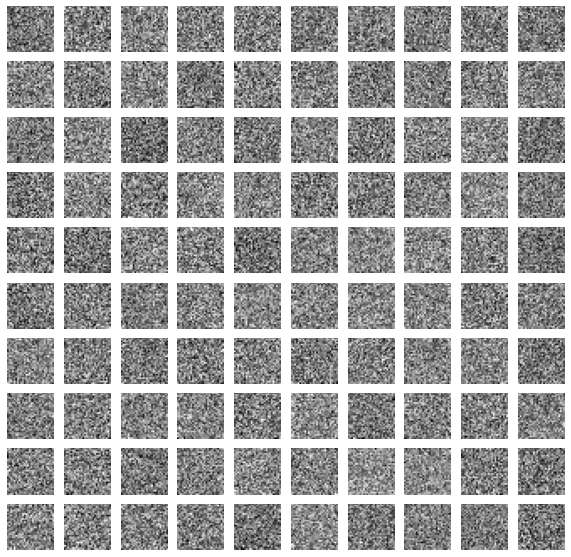

In [74]:
def generate_latent_vector(latent_dim, n_samples):    
    x_input = R.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):    
    x_input = generate_latent_vector(latent_dim, n_samples)    
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

fake = generate_fake_samples(generator, latent_dim, 100)
print(fake[0].shape)
save_plot(fake[0])

In [75]:
def build_discriminator():
    model = Sequential()
    model.add(Dense(256, input_dim=784))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Dense(1, activation='sigmoid'))    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 256)               200960    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 257       
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
_________________________________________________________________


In [76]:
def build_gan(g_model, d_model):    
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

gan = build_gan(generator, discriminator)
gan.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 784)               227344    
_________________________________________________________________
sequential_21 (Sequential)   (None, 1)                 201217    
Total params: 428,561
Trainable params: 227,344
Non-trainable params: 201,217
_________________________________________________________________


In [77]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):    
    X_real, y_real = generate_real_samples(dataset, n_samples)    
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)    
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)    
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)    
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))    
    save_plot(x_fake)

>Accuracy real: 76%, fake: 92%


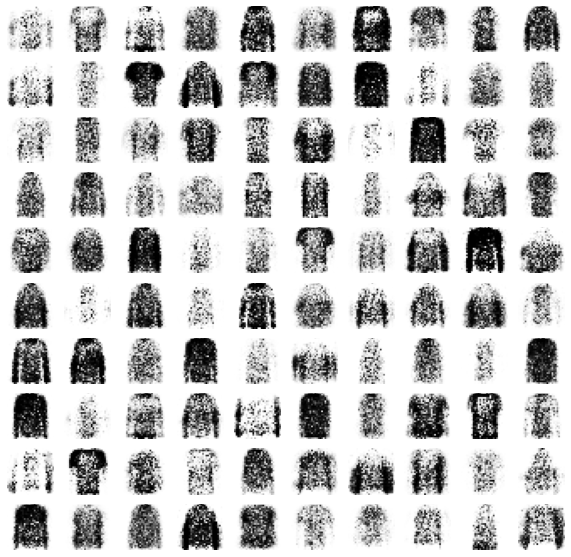

>Accuracy real: 70%, fake: 96%


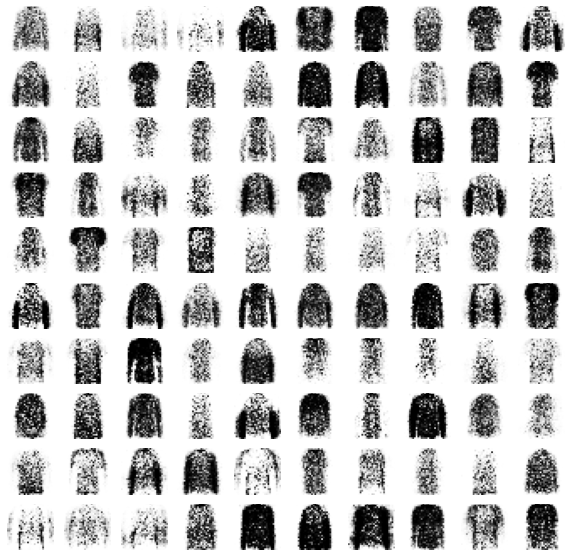

>Accuracy real: 85%, fake: 79%


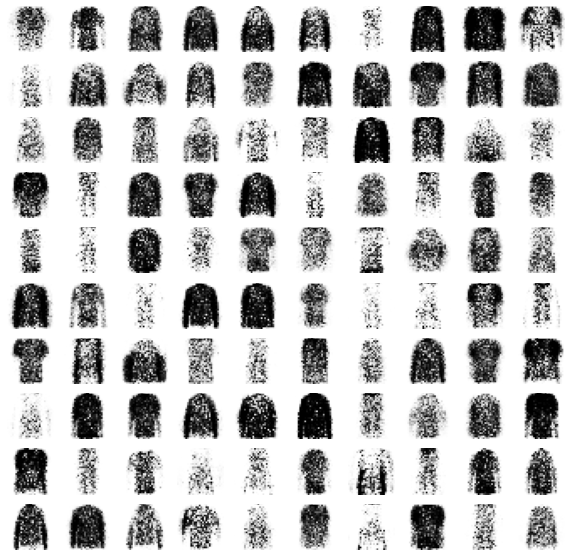

>Accuracy real: 76%, fake: 79%


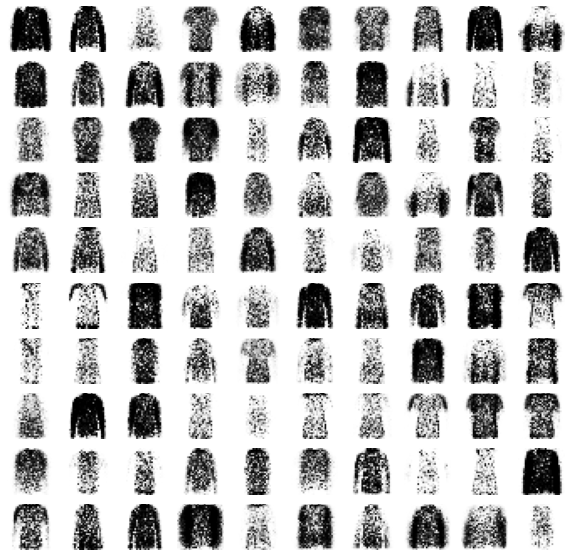

>Accuracy real: 55%, fake: 98%


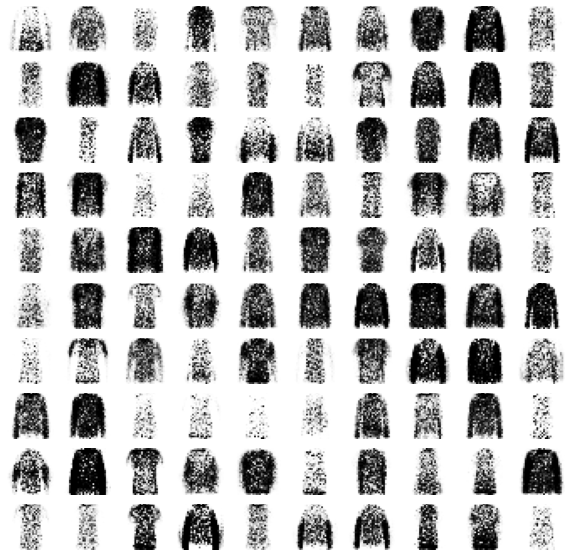

In [79]:
batch_size = 256
epochs = 50
bat_per_epo = int(dataset.shape[0] / batch_size)
half_batch = int(batch_size / 2)

for i in np.arange(0,epochs,10):  
    for j in range(bat_per_epo):    
        X_real, y_real = generate_real_samples(dataset, half_batch)    
        X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)    
        X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))    
        d_loss, _ = discriminator.train_on_batch(X, y)    
        X_gan = generate_latent_vector(latent_dim, batch_size)    
        y_gan = np.ones((batch_size, 1))    
        g_loss = gan.train_on_batch(X_gan, y_gan)    
    summarize_performance(i, generator, discriminator, dataset, 100)